In [ ]:
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import HTMLConverter,TextConverter,XMLConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from io import BytesIO, StringIO
from bs4 import BeautifulSoup
from bs4 import NavigableString
from bs4 import Tag
import re
import pandas as pd
import operator
import math
from collections import Counter
import numpy as np
from pdf2image import convert_from_path
import cv2

In [4]:
def convert(fname, case='text', pages=None):
    if not pages: pagenums = set();
    else:         pagenums = set(pages);      
    manager = PDFResourceManager() 
    la = LAParams()
    caching = True

    if case == 'text' :
        output = StringIO()
        converter = TextConverter(manager, output, laparams=la)     
    elif case == 'HTML' :
        output = StringIO()
        converter = HTMLConverter(manager, output, laparams=la)
    elif case == 'XML' :
        output = StringIO()
        converter = XMLConverter(manager, output, laparams=la)
    else:
        return

    interpreter = PDFPageInterpreter(manager, converter)   
    infile = open(fname, 'rb')

    for page in PDFPage.get_pages(infile, pagenums, caching=caching, check_extractable=True):
        interpreter.process_page(page)

    convertedPDF = output.getvalue()  

    infile.close(); converter.close(); output.close()
    return convertedPDF

In [5]:
def soup(doc):
    soup = BeautifulSoup(doc)
    return soup

In [6]:
def extractInfoFromXML(soup):
    #bottom left and top right coordinates in xml bbox 
    wordList = soup.find_all('textline')
    words_in_textline = ""
    fonts = {}
    point_size = {}
    font = ""
    size = ""
    wList = []
    
    for textline in wordList:
        for text in textline:
            if isinstance(text, NavigableString):
                continue
            if isinstance(text, Tag) and text.get('bbox') != None:
                words_in_textline += text.text
                #Point size of the majority of its constituent words.
                #Font of the majority of its constituent words.
                #Coordinates relating to its position on the page.
                if text.get('font') in fonts.keys(): 
                    fonts[""+text.get('font')] += 1
                else:
                    fonts[""+text.get('font')] = 1
                
                if text.get('size') in point_size.keys(): 
                    point_size[""+text.get('size')] += 1
                else:
                    point_size[""+text.get('size')] = 1
                    
        font = max(fonts.items(), key=operator.itemgetter(1))[0]
        size = max(point_size.items(), key=operator.itemgetter(1))[0]
        bb = textline.get('bbox').split(',')
        xm = (float(bb[2])+float(bb[0]))/2
        ym = (float(bb[3])+float(bb[1]))/2
        wList.append((size,words_in_textline,bb[0],bb[1],xm,ym,bb[2],bb[3],font))
        
        fonts = {}
        point_size = {}
        words_in_textline = ""
        
    data = pd.DataFrame(wList)
    data.columns = ["font_size", "text", "x0","y0","xm","ym","x1","y1","font_family"]
    data[["x0","y0","xm","ym","x1","y1"]] = data[["x0","y0","xm","ym","x1","y1"]].apply(pd.to_numeric)
    
    return (data)

In [7]:
def segmentByFontAndSize(data):
    #Phase two, geometric segmentation of text regions
    dfs = dict(tuple(data.groupby([data['font_size'],data['font_family']])))
    df_list = []
    for key in dfs.keys():
        df_list.append(pd.DataFrame(dfs[key]))
    return df_list

In [8]:
def makeSubBins(df_list):
    sub_bins_list = []
    for df in df_list:
        #apply counter at each coordinate
        x0 = Counter(list(df['x0'])).most_common()
        x1 = Counter(list(df['x1'])).most_common()

        #select all line with x0 having max count
        most_common_x0 = x0[0][0] 
        dfx0 = df.loc[df['x0'] == most_common_x0]
        #select the longest line from above lines
        longest_common_line = dfx0.sort_values(by ='x1', axis=0, ascending = False).iloc[0]
        x0_line = float(longest_common_line['x0'])
        x1_line = float(longest_common_line['x1'])
        #create subbins of lines on the left and right side of this line
        left_sub_bin = df.loc[df['x1'].astype(float) < x0_line]
        right_sub_bin = df.loc[df['x0'].astype(float) > x1_line]
        #remove left and right subbin from main dataframe to find the mioddle subbin 
        temp = df.loc[~df.set_index(list(df.columns)).index.isin(right_sub_bin.set_index(list(right_sub_bin.columns)).index)]
        middle_sub_bin = temp.loc[~temp.set_index(list(temp.columns)).index.isin(left_sub_bin.set_index(list(left_sub_bin.columns)).index)]
        sub_bins_list.append((left_sub_bin,middle_sub_bin,right_sub_bin))
    
    return sub_bins_list

In [9]:
#calculate the threshold of line spacing
#-1 for empty dataframe and -2 for mono entry
def calculateThreshLists(sub_bins_list):
    thresh_list = []
    for sub_bin_tuple in sub_bins_list:
        thresh_tuple = []
        for df in sub_bin_tuple:
            if len(df) > 1:
                thresh = 0
                df = df.sort_values(by ='y0', axis=0, ascending = False)
                df['diff_y0'] = (df['y0'] - df['y0'].shift(-1))
                th_list = Counter(list(map(math.ceil,(list(df['diff_y0'][:-1]))))).most_common()
                temp = [i[0] for i in th_list]
                if(len(set([i[1] for i in th_list]))==1):
                    temp.sort()
                    thresh = temp[0]
                else:
                    if th_list[0][0] != 0:
                        thresh = th_list[0][0]
                    else:
                        thresh = th_list[1][0]
                thresh_tuple.append(thresh)
            elif len(df) == 1:
                thresh_tuple.append(-2)
            else:
                thresh_tuple.append(-1)
        thresh_list.append(thresh_tuple)
    return thresh_list

In [10]:
def paragraphsInColumn(thresh,column):
    lab = 0
    sbin = column.sort_values(by ='y0', axis=0, ascending = False)
    y0 = list(sbin['y0'].values)
    labels = list(np.zeros(len(sbin)))
    for i,val1 in enumerate(y0):
        for j,val2 in enumerate(y0):
            if abs(val1 - val2) <= thresh + 2:
                if(labels[i] == 0 and labels[j] == 0):
                    lab += 1
                    labels[i] = lab
                    labels[j] = lab
                else:
                    labels[i] = lab
                    labels[j] = lab   
    return labels

In [11]:
def paragraphsInSubBins(thresh_list, sub_bins_list):
    paragraphsInSubBins = []
    paragraphs = []
    for i in range(len(thresh_list)):
        for j in range(len(thresh_list[0])):
            if thresh_list[i][j] == -1:
                paragraphs.append([-1])
            elif thresh_list[i][j] == -2:
                paragraphs.append([1])
            else:
                paragraphs.append(paragraphsInColumn(thresh_list[i][j], sub_bins_list[i][j]))
        paragraphsInSubBins.append(paragraphs)
        paragraphs = []
    return paragraphsInSubBins

In [12]:
def newparagraphsInSubBins(thresh_list, sub_bins_list):
    paragraphs = sub_bins_list
    for i in range(len(thresh_list)):
        for j in range(len(thresh_list[0])):
            if thresh_list[i][j] == -1:
                continue
            elif thresh_list[i][j] == -2:
                paragraphs[i][j]['pTag'] = [1]
            else:
                paragraphs[i][j]['pTag'] = paragraphsInColumn(thresh_list[i][j], sub_bins_list[i][j])
        
    return paragraphs

In [13]:
doc = convert('./data/sample.pdf','XML')
s = soup(doc)
data = extractInfoFromXML(s)
bins_list = segmentByFontAndSize(data)
sub_bins_list = makeSubBins(bins_list)
thresh_list = calculateThreshLists(sub_bins_list)
paragraphs = newparagraphsInSubBins(thresh_list, sub_bins_list)

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [14]:
paragraphs[0][1]

,font_size,text,x0,y0,xm,ym,x1,y1,font_family,pTag
2,10.258,To work in a highly professional and competitive,38.850,761.931,135.9190,767.0600,232.988,772.189,QEBAAA+Ubuntu-Regular,1
3,10.258,environment where i can learn and gain practical,38.850,750.961,136.3620,756.0905,233.874,761.220,QEBAAA+Ubuntu-Regular,1
4,10.258,experience that will help me improve my skills.,38.850,739.992,132.3710,745.1210,225.892,750.250,QEBAAA+Ubuntu-Regular,1
14,10.258,Android Application Development Engineer,47.762,592.135,135.5900,597.2640,223.418,602.393,QEBAAA+Ubuntu-Regular,2
21,10.258,Information Technology Department,47.762,489.754,121.9030,494.8835,196.044,500.013,QEBAAA+Ubuntu-Regular,3
98,10.258,Software Construction,47.762,155.647,93.3370,160.7760,138.912,165.905,QEBAAA+Ubuntu-Regular,4
99,10.258,Artiﬁcial Intelligence,47.762,142.850,89.7420,147.9790,131.722,153.108,QEBAAA+Ubuntu-Regular,4
100,10.258,Digital Image Processing,47.762,130.052,97.4110,135.1810,147.060,140.310,QEBAAA+Ubuntu-Regular,4
101,10.258,Web Engineering,47.762,117.254,82.2300,122.3835,116.698,127.513,QEBAAA+Ubuntu-Regular,4
102,10.258,Distributed Computing,47.762,93.488,94.1295,98.6170,140.497,103.746,QEBAAA+Ubuntu-Regular,4


In [17]:
from wand.image import Image as wi 
from wand.drawing import Drawing
from wand.color import Color

In [18]:
def drawRect(img,bbox,color, sw):
    rlist= bbox
    ys = img.size[1];
    xl = rlist.copy()
    xl[1] = ys - rlist[3] - 10
    xl[3] = ys - rlist[1] + 10

    with Drawing() as draw:
        draw.fill_opacity=0;
        draw.stroke_width=sw;
        draw.stroke_color=color;
        draw.rectangle(left=xl[0],top=xl[1],right=xl[2], bottom=xl[3])
        draw(img)
    return img

In [19]:
Bins = []
Columns = []
coord = []
for i in range(len(paragraphs)):
    for j in range(len(paragraphs[0])):
        df = paragraphs[i][j]
        if len(paragraphs[i][j]) == 0:
            continue
        else:
            for e, g in df.groupby(['pTag']):
                coord.append(g['x0'].max())
                coord.append(g.iloc[[-1]]["y1"].values[0])
                coord.append(g['x1'].max())
                coord.append(g.iloc[[0]]["y0"].values[0])
                Columns.append(coord)
                coord = []
    Bins.append(Columns)
    Columns = []

In [ ]:
Bins[5]

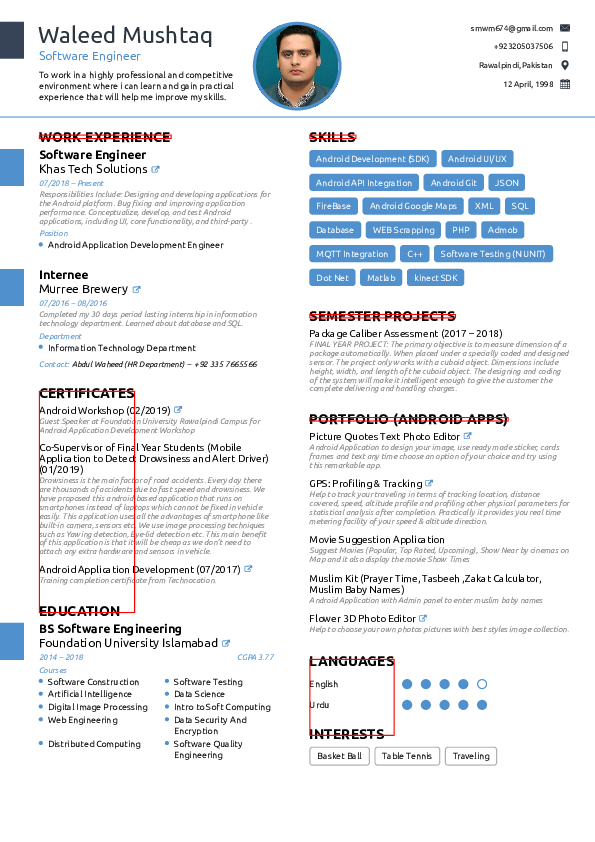

In [33]:
images = wi(filename="./data/sample.pdf")
img = None
for index,ims in enumerate(images.sequence):
    #Prepare the image.
    img=wi(ims)
    #Trun off alpha channel
    img.alpha_channel='remove'
    #[x0,y1,max(x1),y0]
    
    for bbox in Bins[4]:
        img = drawRect(img, bbox, Color('red'),1)
img

In [ ]:
images.sequence